<a href="https://colab.research.google.com/github/LeeChangWon-ahn/thethethethetehteh/blob/main/channelx3_epoch%2B5_acc94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from scipy.signal import find_peaks
from scipy import io
import scipy.io.wavfile
from scipy.io.wavfile import write
import numpy as np
from numpy import fft
import math
from math import exp, sqrt
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import random
from random import randint
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential,datasets
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,concatenate,UpSampling2D,Dropout,MaxPooling2D, Conv1DTranspose, Permute,Lambda, Input, Add, Concatenate, Dense, GRU, ReLU, Activation, Reshape, SeparableConv1D,Conv1D, Conv2D, Conv1DTranspose, BatchNormalization, Bidirectional, SeparableConv2D
from tensorflow.keras.layers.experimental import preprocessing
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import os
from tqdm import tqdm
import torch

In [ ]:
rootpath = '/content/drive/MyDrive/aeiou'

In [ ]:
data = dict()

for i in os.scandir(rootpath):
  if i.name.startswith('75'):
    _, n = i.name.split('_',1) #(75Raw, i.txt)
    n = n.split('.')[0]
    with open(i,'r') as f:
      d = [float(i.strip()) for i in f.readlines()] #0.003
      data[n] = [d[i*20000:((i+1)*20000)-1] for i in range(75)]


In [ ]:
x = ['a','e','i','o','u']
for i in range(5):
    data[x[i]] = np.array(data[x[i]])

In [ ]:
train_num = 60
val_num = 7
test_num = 8
label_a = np.zeros(train_num)
label_e = np.zeros(train_num) + 1
label_i = np.zeros(train_num) + 2
label_o = np.zeros(train_num) + 3
label_u = np.zeros(train_num) + 4

train_data = np.concatenate((data['a'][:train_num],data['e'][:train_num],
                             data['i'][:train_num],data['o'][:train_num],
                             data['u'][:train_num]), axis = 0)
train_label = np.concatenate((label_a,label_e,label_i,label_o,label_u))

val_data = np.concatenate((data['a'][train_num:67],data['e'][train_num:67],
                           data['i'][train_num:67],data['o'][train_num:67],
                           data['u'][train_num:67]), axis = 0)
val_label = np.concatenate((label_a[:val_num],label_e[:val_num],
                            label_i[:val_num],label_o[:val_num],
                            label_u[:val_num]))
test_data = np.concatenate((data['a'][-test_num:],data['e'][-test_num:],
                             data['i'][-test_num:],data['o'][-test_num:],
                             data['u'][-test_num:]), axis = 0)
test_label = np.concatenate((label_a[:test_num],label_e[:test_num],
                            label_i[:test_num],label_o[:test_num],
                            label_u[:test_num]))


In [ ]:
#data 전처리
#44100 / 512 = 86.13 만큼 잘라서 1칸
tran_data = np.zeros((300,128,128))
for i in range(300):
  asd = librosa.feature.melspectrogram(y= train_data[i], sr = 44100,n_fft = 314, hop_length = 157, win_length = 314)
  tran_data[i] = asd

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


In [ ]:
train_data_stft = torch.tensor(train_data)

In [ ]:
tran_data_stft = torch.zeros((300,128,128,2))
for i in range(300):
    fgh = torch.stft(input=train_data_stft[i], n_fft = 255,hop_length = 157,
                 normalized = True, return_complex = False)
    tran_data_stft[i] = fgh
tran_data_stft = tran_data_stft.numpy()

In [ ]:
tran_data = np.expand_dims(tran_data,3)

In [ ]:
re = np.concatenate((tran_data_stft,tran_data), axis = 3)

In [ ]:
vals_data = np.zeros((35,128,128))
for i in range(35):
  zzz = librosa.feature.melspectrogram(y= val_data[i], sr = 44100,n_fft = 314, hop_length = 157, win_length = 314)
  vals_data[i] = zzz

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


In [ ]:
val_data_tensor = torch.tensor(val_data)
vals_data_stft = torch.zeros((35,128,128,2))
for i in range(35):
    xyz = torch.stft(input=val_data_tensor[i], n_fft = 255,hop_length = 157,
                 normalized = True, return_complex = False)
    vals_data_stft[i] = xyz
vals_data_stft = vals_data_stft.numpy()

In [ ]:
vals_data = np.expand_dims(vals_data,3)

In [ ]:
val_re = np.concatenate((vals_data_stft,vals_data), axis = 3)

In [ ]:
#test
test_data_mel = np.zeros((40,128,128))
for i in range(40):
  asd = librosa.feature.melspectrogram(y= test_data[i], sr = 44100,n_fft = 314, hop_length = 157, win_length = 314)
  test_data_mel[i] = asd

test_data_tensor = torch.tensor(test_data)
test_data_stft = torch.zeros((40,128,128,2))
for i in range(40):
    fgh = torch.stft(input=test_data_tensor[i], n_fft = 255,hop_length = 157,
                 normalized = True, return_complex = False)
    test_data_stft[i] = fgh
test_data_stft = test_data_stft.numpy()

test_data_mel = np.expand_dims(test_data_mel,3)

test_re = np.concatenate((test_data_stft,test_data_mel), axis = 3)

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


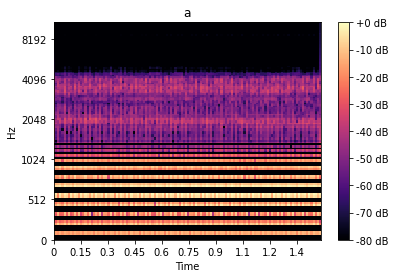

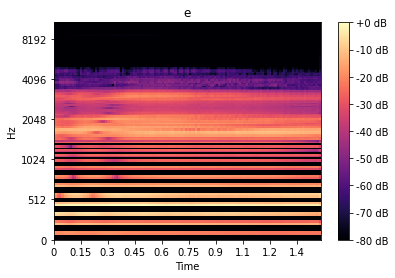

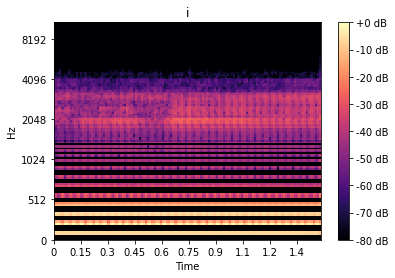

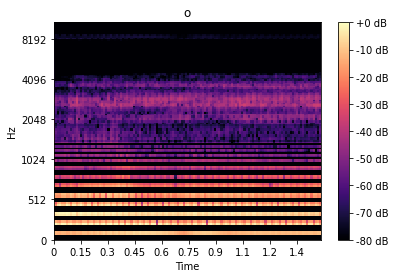

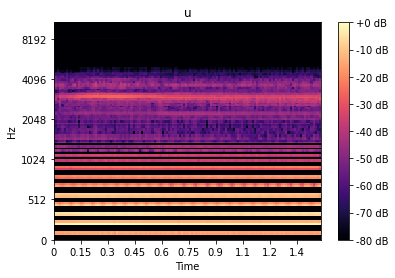

In [ ]:
xxxx = tran_data.reshape(300,128,128)
for i in range(5):
  fig, ax = plt.subplots()
  S_dB_a = librosa.power_to_db(xxxx[i*60], ref = np.max)
  img = librosa.display.specshow(S_dB_a, x_axis = 'time', y_axis = 'mel',
                                 sr = 44100, ax = ax)
  fig.colorbar(img, ax=ax, format = '%+2.0f dB')
  ax.set(title = '{}'.format(x[i]))

In [ ]:

input_shape = (5,128,128,3)
num_labels = 5


model = Sequential()
model.add(Conv2D(96, (3, 3),activation = 'relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3),activation = 'relu' ))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(192, (3, 3),activation = 'relu' ))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())  # 이전 CNN 레이어에서 나온 3차원 배열은 1차원으로 뽑아줍니다
model.add(Dense(192,activation = 'relu' ))
model.add(Dropout(0.5))
model.add(Dense(64,activation = 'relu' ))
model.add(Dropout(0.5))
model.add(Dense(5,activation = 'softmax' ))
    

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 96)      2688      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 96)        83040     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 96)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 192)       166080    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 192)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 37632)            

In [ ]:
model.load_weights('/content/drive/MyDrive/aeiou/3channel_try_acc95.h5')

In [ ]:
np.expand_dims

(128, 128, 3)


In [ ]:
model.predict_classes(test_re) # 40개중 2개 틀림

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 1, 4, 4, 3, 4, 4, 4, 4, 4])

In [ ]:
K.clear_session()

In [ ]:
#epoch 20+5
model.load_weights('/content/drive/MyDrive/aeiou/3channel_try_acc91.h5')
history = model.fit(re, train_label, epochs = 5,
                    validation_data = (val_re,val_label))

Epoch 1/5
10/10 [==============================] - 16s 2s/step - loss: 0.2221 - accuracy: 0.9300 - val_loss: 0.4731 - val_accuracy: 0.9143
Epoch 2/5
10/10 [==============================] - 16s 2s/step - loss: 0.2190 - accuracy: 0.9233 - val_loss: 0.3313 - val_accuracy: 0.9143
Epoch 3/5
10/10 [==============================] - 16s 2s/step - loss: 0.2252 - accuracy: 0.9300 - val_loss: 0.3478 - val_accuracy: 0.9143
Epoch 4/5
10/10 [==============================] - 16s 2s/step - loss: 0.2189 - accuracy: 0.9300 - val_loss: 0.3956 - val_accuracy: 0.8857
Epoch 5/5
10/10 [==============================] - 16s 2s/step - loss: 0.1755 - accuracy: 0.9400 - val_loss: 0.5118 - val_accuracy: 0.8857


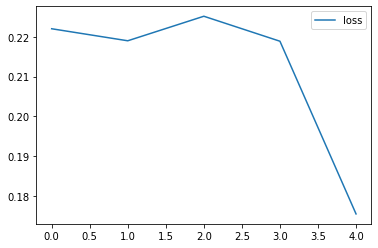

In [ ]:

metrics = history.history
plt.plot(history.epoch, metrics['loss'])
plt.legend(['loss'])
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_re,  test_label, verbose=2)
print('\n테스트 정확도:', test_acc)

2/2 - 1s - loss: 0.2319 - accuracy: 0.9500

테스트 정확도: 0.949999988079071


In [ ]:
model.save_weights('/content/drive/MyDrive/aeiou/3channel_try_acc94.h5')